In [180]:
import pandas as pd

folder = './numberofServices/v'

#folder = '../ftgo/multiple/v'
#resFolder = "/res"

#transactionLabels = ["getDeliveryNotification", "itemviewer_getMenu"]

transactionLabels = ["AMQP Consumer"]

def loadMetrics(version):
    metrics = pd.read_excel(folder + str(version) + '/metricsorderNumberOfServices_V' + str(version) + '.xlsx', 1)

    metrics = metrics.rename(columns={'Unnamed: 0': "metric"})
    return metrics

def getTransactions(version):

    transactions = pd.read_csv(folder + str(version)  +'/result.jtl')

    transactions['timeStamp'] = pd.to_datetime(transactions['timeStamp'], unit='ms')

    dict = {}

    for label in transactionLabels:
        tmp = transactions.loc[transactions['label'] == label]

        tmp = tmp[tmp['success'] == True]
        

        startEnd = tmp.iloc[[0, -1]]


        duration = startEnd.iloc[1]['timeStamp'] - startEnd.iloc[0]['timeStamp']

        dict[label] =  len(tmp) / duration.seconds #[len(tmp) / duration.seconds]
    
    dict["notifyClientOfDelivery"] = dict.pop("AMQP Consumer")

    return dict

def combineThroughput(versions):

    res = pd.DataFrame()

    for version in versions:
        p = getTransactions(version)

        frame = pd.DataFrame.from_dict(p, orient='index',
                       columns=['V' + str(version)])

        res = pd.concat([res, frame], axis=1)

    return res

def combinePerformance(versions):
    allSeries = []
    for version in versions:
        perf = pd.read_csv('./results/v' + str(version) + '/podPerformance.csv')

        perf['timestamp'] = pd.to_datetime(perf['timestamp'])

        meanPodCpu = perf.pivot(index='timestamp', columns='pod', values='cpu').mean()


        res = pd.Series()
        res['cpu (std)'] = meanPodCpu.std() / 10000000
        res['memory (mean)'] = perf['memory'].mean() / 100000
        res['memory (std)'] = perf['memory'].std() / 100000

        allSeries.append(res.rename("V" + str(version)))
    
    return pd.concat(allSeries, axis=1)

def combineMetrics(versions):
    df = pd.DataFrame()

    for version in versions:
        m = loadMetrics(version)

        df['metric'] = m['metric']
        df['V' + str(version)] = m['orderFood']

    return df


In [181]:
versionsToView = [1,2,3]

In [182]:
combineThroughput(versionsToView)

,V1,V2,V3
notifyClientOfDelivery,6.921348,6.314607,5.865169


In [183]:
combinePerformance(versionsToView)


/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()


,V1,V2,V3
cpu (std),8.227048,6.736303,8.330783
memory (mean),1.506554,1.515813,1.526011
memory (std),0.217980,0.190589,0.189284


/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
/var/folders/vs/yq8ljrx54cq1p65m2qkgffhh0000gn/T/ipykernel_6493/3689489670.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
/opt/homebrew/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's

Text(0.5, 0, 'Throughput/Metric Value')

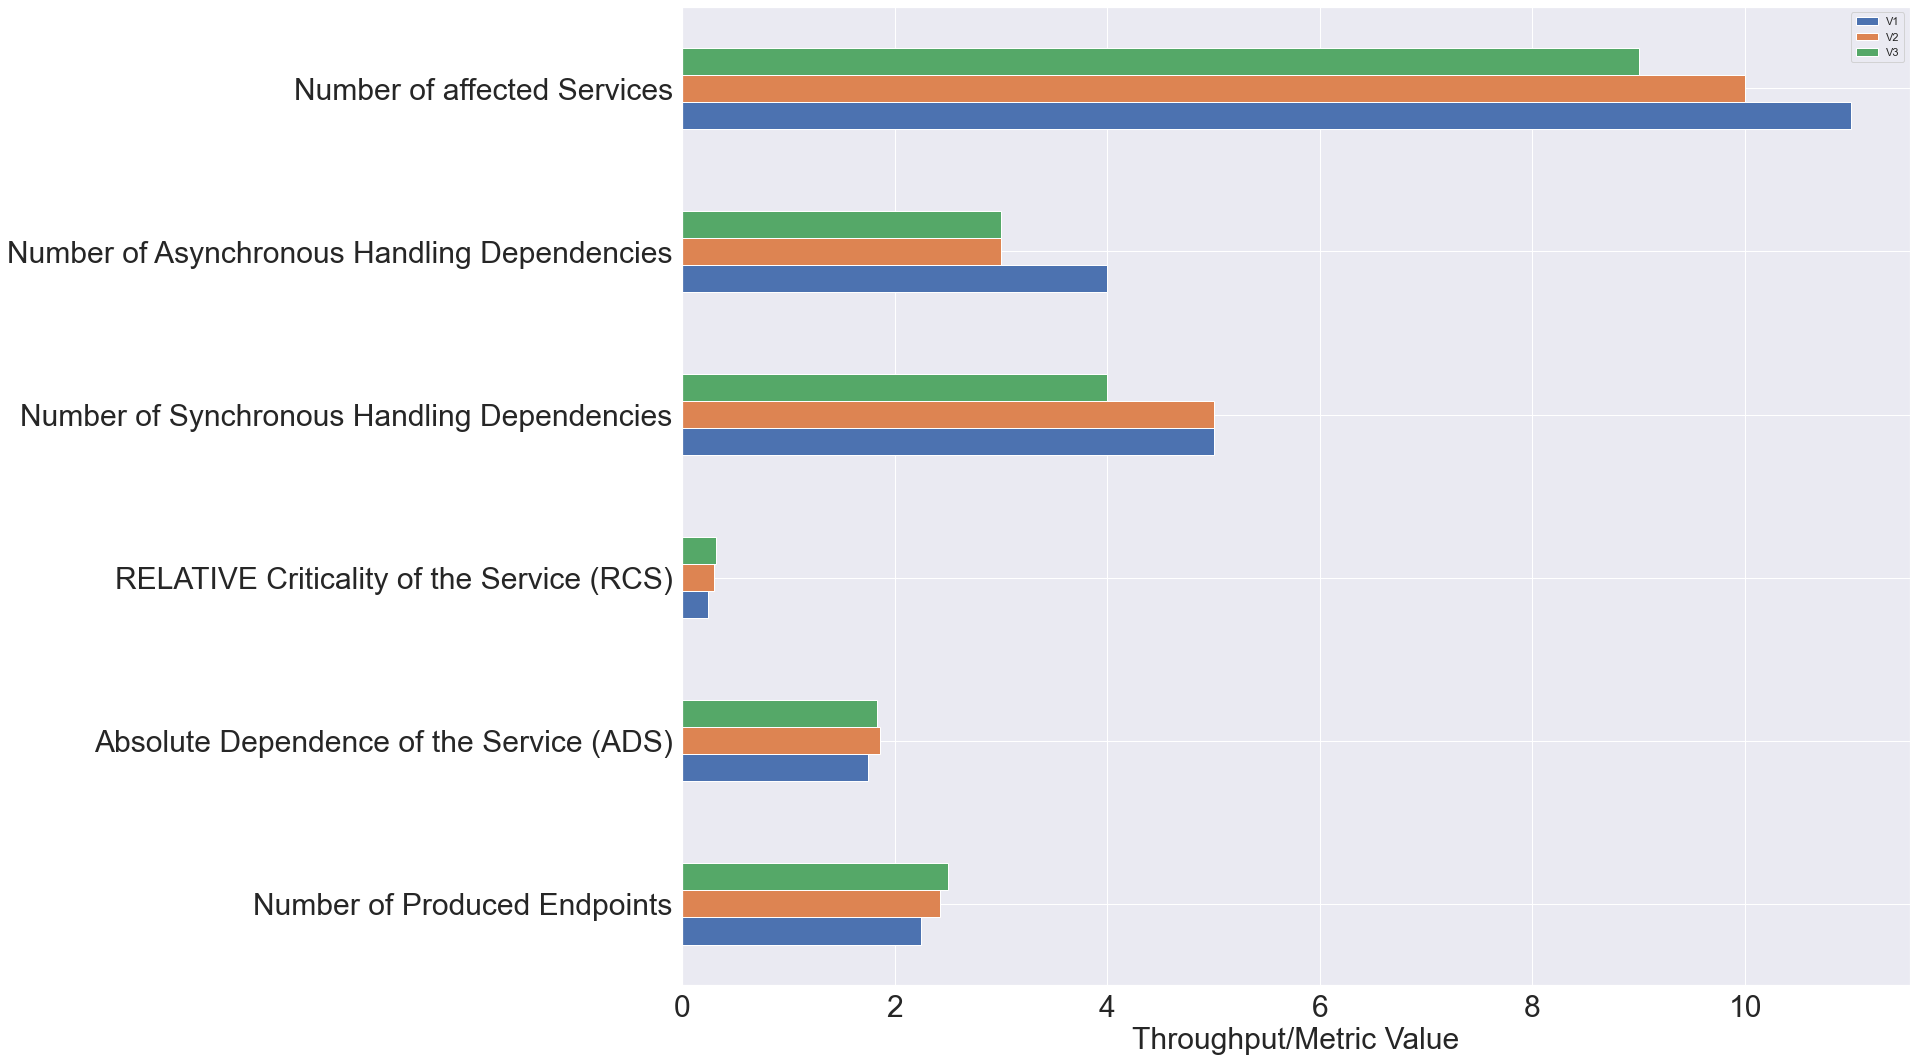

In [184]:
throughput = combineThroughput(versionsToView)

throughput = throughput.reset_index()
throughput = throughput.rename(columns={"index": "metric"})

performance = combinePerformance(versionsToView)
performance['metric'] = performance.index

combined = pd.concat([throughput, performance, combineMetrics(versionsToView)]).reset_index(drop=True)

combined = combined.iloc[[4,14,18,19,20,23]]

#combined
ax = combined.plot.barh(x='metric', figsize=(22,18), fontsize=30)

y_axis = ax.axes.set_ylabel(None)

ax.set_xlabel("Throughput/Metric Value",fontdict={'fontsize':30})

In [185]:
import seaborn as sns

temp = combined.T #.plot.bar(x='metric', figsize=(16,8))

temp = temp[[4,17,18,19,20,23]]

new_header = temp.iloc[0] #grab the first row for the header
temp = temp[1:] #take the data less the header row
temp.columns = new_header #set the header row as the df header

temp = temp.astype(float)

normalized_df=(temp-temp.mean())/temp.std()

# pearson kendall
corr = normalized_df.corr(method='pearson')

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

KeyError: '[17] not in index'